In [1]:
pip install svgpath2mpl svgpathtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 9.3 MB/s eta 0:00:00


In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from sklearn.neighbors import NearestNeighbors
from numba import jit
from scipy import sparse
import pandas as pd

In [2]:
df = pd.read_csv('combined_peaks_named.csv')
df.describe()

,peak_area,RT1_center,RT2_center,RT1_start,RT2_start,RT1_end,RT2_end,m/z,class
count,8.640000e+02,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,7.295166e+05,7280.061889,1.527361,7279.895611,1.556528,7281.432667,1.494111,194.075231,0.658565
std,2.471182e+06,2000.966258,0.425301,2000.837822,0.432232,2001.059576,0.418226,106.740750,0.474466
min,1.501200e+04,2953.360000,1.008000,2953.360000,1.024000,2953.360000,0.976000,30.000000,0.000000
25%,6.932407e+04,5987.824000,1.176000,5987.824000,1.200000,5987.824000,1.144000,116.000000,0.000000
50%,2.107435e+05,7529.584000,1.420000,7529.584000,1.448000,7529.584000,1.384000,168.000000,1.000000
75%,6.333406e+05,9074.848000,1.880000,9074.848000,1.906000,9074.848000,1.824000,248.000000,1.000000
max,4.985909e+07,11103.664000,3.472000,11103.664000,3.496000,11103.664000,3.440000,671.000000,1.000000


In [3]:
df['sample_name'] = df['sample_name'].str.replace('_', ' ')
df['sample_name'] = df['sample_name'].replace('Icerland Soil', 'Iceland Soil')
df['sample_name'] = df['sample_name'].replace('Utha Soil', 'Utah Soil')

In [15]:
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler

df1 = df[df['class'] == 0]
df2 = df[df['class'] == 1]

features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

# Normalize all features
scaler = StandardScaler()
scaler.fit(features_all)
features_class0 = scaler.transform(features_class0_)
features_class1 = scaler.transform(features_class1_)

# Fit Gaussian models for each class
mean0 = np.mean(features_class0, axis=0)
cov0 = np.cov(features_class0, rowvar=False)

mean1 = np.mean(features_class1, axis=0)
cov1 = np.cov(features_class1, rowvar=False)

dist0 = multivariate_normal(mean=mean0, cov=cov0)
dist1 = multivariate_normal(mean=mean1, cov=cov1)

# Function to calculate the gradient of the log PDF at a point
def gradient_log_pdf(point, mean, cov):
    inv_cov = np.linalg.inv(cov)
    return inv_cov @ (point - mean)

# Example: Calculate gradient for a point from class 0 towards class 1 mean
point_index = 0
point = features_class0[point_index]

gradient = gradient_log_pdf(point, mean1, cov1)

# Calculate gradients for each point in class 0
gradients = np.array([gradient_log_pdf(point, mean1, cov1) for point in features_class0])
df1['grad_RT1'] = gradients[:, 0]
df1['grad_RT2'] = gradients[:, 1]
df1['grad_m/z'] = gradients[:, 2]

# Rescale the gradients for visual purposes
scaled_gradients = -1*(gradients * scaler.scale_ + scaler.mean_)

/tmp/ipykernel_538309/3014686728.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['grad_RT1'] = gradients[:, 0]
/tmp/ipykernel_538309/3014686728.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['grad_RT2'] = gradients[:, 1]
/tmp/ipykernel_538309/3014686728.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

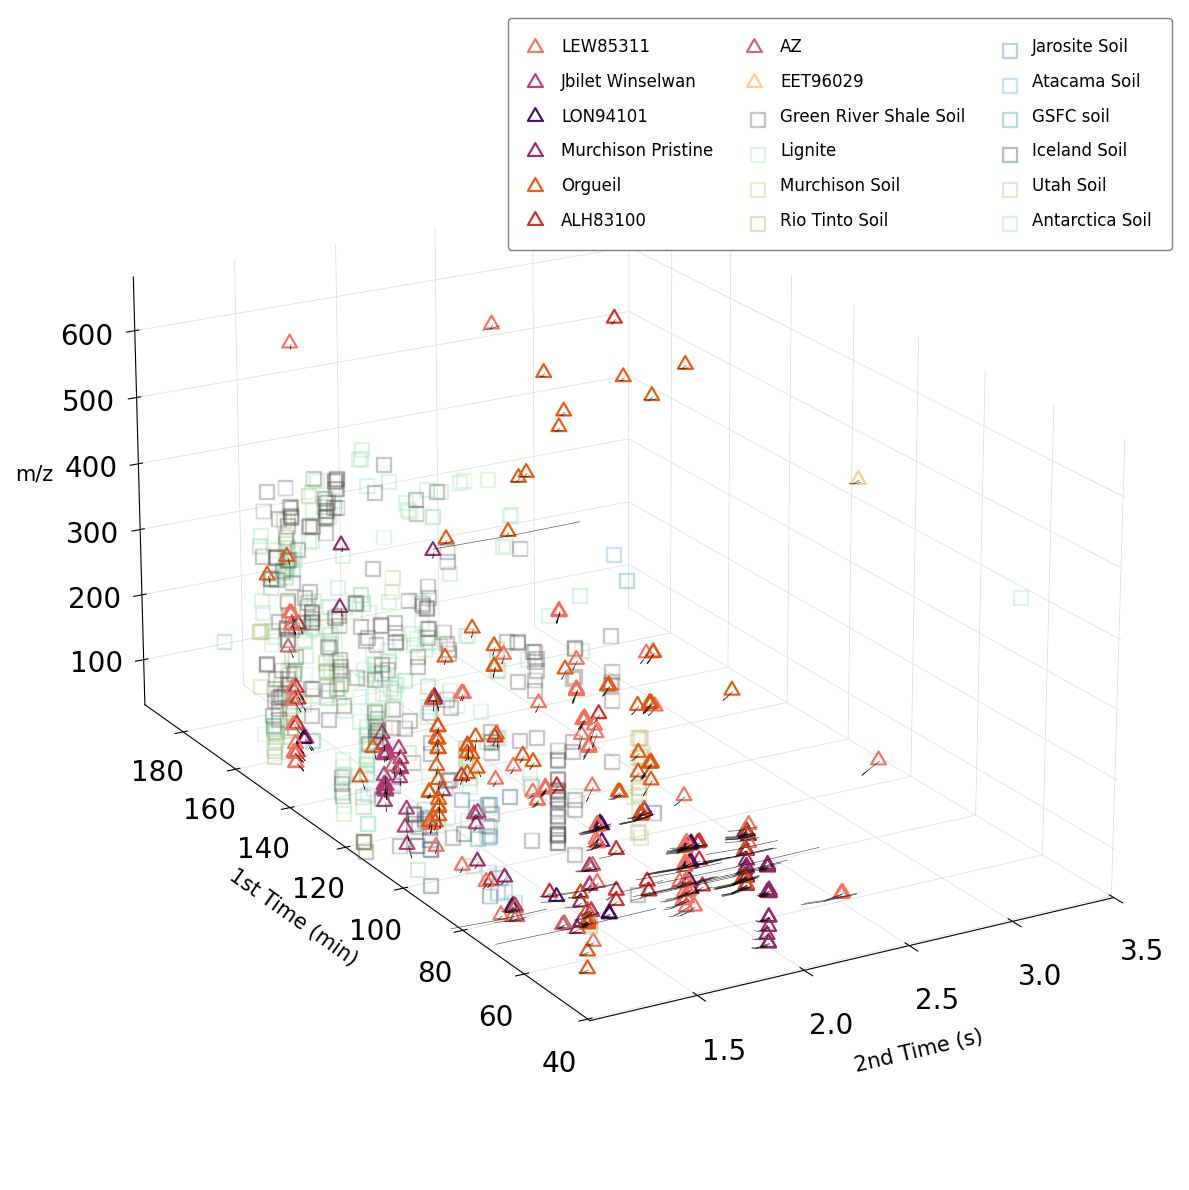

In [16]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import random
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.markers import MarkerStyle

def get_marker(svg_path):
    cwd = os.getcwd()
    custom_path, attributes = svg2paths(svg_path)
    marker = parse_path(attributes[0]['d'])
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

def plot_peak_gradients(peaks_features_df, samples, df1, gradients, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers
    oval = Path([(1,-1), (-1,-1), (-1,1), (1,1), (1,-1)], [Path.MOVETO, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.LINETO])

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    # Plot each class
    for class_id, markers, colors in zip([0, 1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = samples[samples['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.23
                colors = colors_biotic
            else:
                alpha = 0.9
                colors = colors_abiotic
            if class_id == 1:
                size = 200
            else:
                size = 200

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'] / 60.0,
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )

    quiver_scale = 5 if view == "small" else 7
    quiver_kwargs = dict(length=quiver_scale, normalize=True, colors="black", linewidth=0.45, edgecolors='k', alpha=0.7)
    ax.quiver(df1['RT2_center'], df1['RT1_center'] / 60.0, df1['m/z'],
              scaled_gradients[:, 1], scaled_gradients[:, 0] / 60.0, scaled_gradients[:, 2],
              **quiver_kwargs)

    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    #ax.set_ylim(peaks_features_df['RT1_center'].min(), 190)
    ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.savefig('peak_gradients_figure.pdf', dpi=300)
    plt.show()
    plt.close()

plot_peak_gradients(df, df, df1, scaled_gradients, '/content/', view='small')

In [11]:
# Function to calculate the gradient of the log PDF at a point
def gradient_log_pdf(point, mean, cov):
    inv_cov = np.linalg.inv(cov)
    return inv_cov @ (point - mean)


def gradient_descent(df):
    df1 = df[df['class'] == 0]
    df2 = df[df['class'] == 1]

    # Create a dataframe including both retention times and mass/charge
    features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
    features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
    features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

    # Normalize all features for gradient calculation
    scaler = StandardScaler()
    scaler.fit(features_all)
    features_class0 = scaler.transform(features_class0_)
    features_class1 = scaler.transform(features_class1_)

    # Create a multivariate Gaussian distribution for biotic features
    mean1 = np.mean(features_class1, axis=0)
    cov1 = np.cov(features_class1, rowvar=False)
    dist1 = multivariate_normal(mean=mean1, cov=cov1)

    rt1 = [features_class0_[:, 0]]
    rt2 = [features_class0_[:, 1]]
    mz = [features_class0_[:, 2]]
    grad_rt1 = []
    grad_rt2 = []
    grad_mz = []

    features = features_class0

    # 'Learning' rate - controls how influential gradients are
    alpha = 1

    time_steps = 50
    for t in range(time_steps):
        # Compute gradient and move in that direction
        gradients = np.array([gradient_log_pdf(point, mean1, cov1) for point in features])
        features -= (alpha / ((t + 1)*5)) * gradients

        # Update new feature locations
        rt1.append(features[:, 0] * scaler.scale_[0] + scaler.mean_[0])
        rt2.append(features[:, 1] * scaler.scale_[1] + scaler.mean_[1])
        mz.append(features[:, 2] * scaler.scale_[2] + scaler.mean_[2])

        # Save gradients for later analysis
        grad_rt1.append(gradients[:, 0])
        grad_rt2.append(gradients[:, 1])
        grad_mz.append(gradients[:, 2])

    return rt1, rt2, mz, grad_rt1, grad_rt2, grad_mz

rt1, rt2, mz, grad_rt1, grad_rt2, grad_mz = gradient_descent(df)

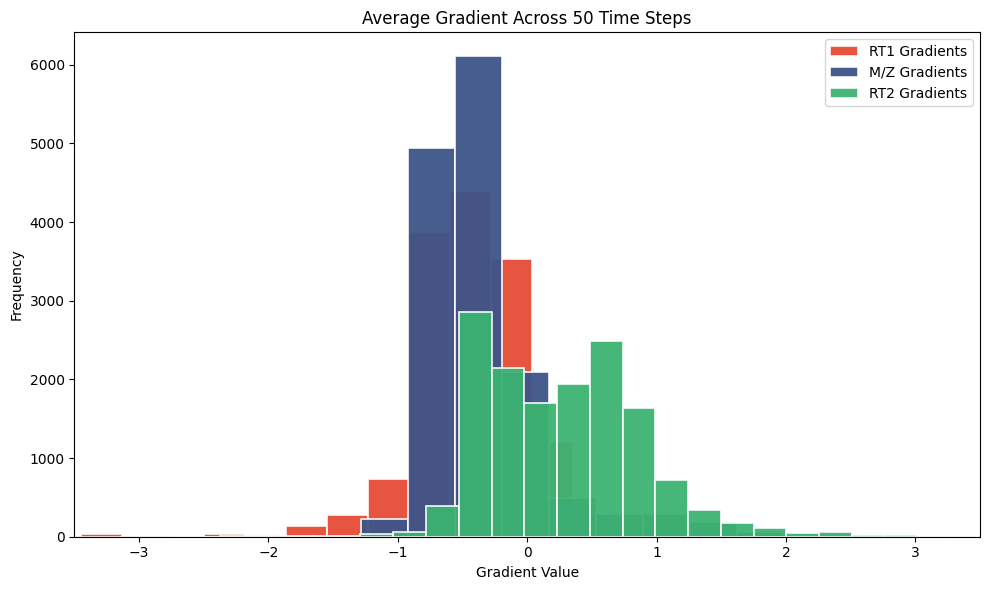

In [38]:
def plot_overlapping_average_gradient(grad_rt1, grad_rt2, grad_mz):
    # Concatenate gradient arrays
    data_rt1 = np.concatenate(grad_rt1)
    data_rt2 = np.concatenate(grad_rt2)
    data_mz = np.concatenate(grad_mz)

    # Compute average values
    avg_rt1 = np.mean(data_rt1)
    avg_rt2 = np.mean(data_rt2)
    avg_mz = np.mean(data_mz)

    palette = ['#e64b35','#3c5488','#9E3DFF']

    # Prepare data for plotting
    data = [
        (data_rt1, avg_rt1, 'RT1 Gradients', palette[0]),
        (data_rt2, avg_rt2, 'RT2 Gradients', 'mediumseagreen'),
        (data_mz, avg_mz, 'M/Z Gradients', palette[1])
    ]

    # Sort data by average value to plot higher averages last
    data.sort(key=lambda x: x[1])

    plt.figure(figsize=(10, 6))

    # Plot histograms in the sorted order
    for values, avg, label, color in data:
        plt.hist(values, bins=30, color=color, alpha=0.95, label=label, edgecolor='white', linewidth=1.2)

    # Customize the plot
    plt.title('Average Gradient Across 50 Time Steps')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.xlim([-3.5, 3.5])
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(False)
    #plt.savefig('average_gradients.pdf', dpi=300)
    plt.show()

plot_overlapping_average_gradient(grad_rt1, grad_rt2, grad_mz)

In [8]:
df1 = df[df['class'] == 0]
df2 = df[df['class'] == 1]

# Create a dataframe including both retention times and mass/charge
features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

# Normalize all features for gradient calculation
scaler = StandardScaler()
scaler.fit(features_all)
features_class0 = scaler.transform(features_class0_)
features_class1 = scaler.transform(features_class1_)

# Create a multivariate Gaussian distribution for biotic features
mean1 = np.mean(features_class1, axis=0)
cov1 = np.cov(features_class1, rowvar=False)
dist1 = multivariate_normal(mean=mean1, cov=cov1)

print('Mean: ', mean1)
print('Covariance: ', cov1)
print('Scaled mean: ', mean1 * scaler.scale_ + scaler.mean_)

Mean:  [ 0.41000078 -0.18346639  0.19133658]
Covariance:  [[0.59210896 0.03183212 0.40285076]
 [0.03183212 0.77422158 0.05277957]
 [0.40285076 0.05277957 0.86705037]]
Scaled mean:  [8.09998470e+03 1.44937786e+00 2.14486819e+02]


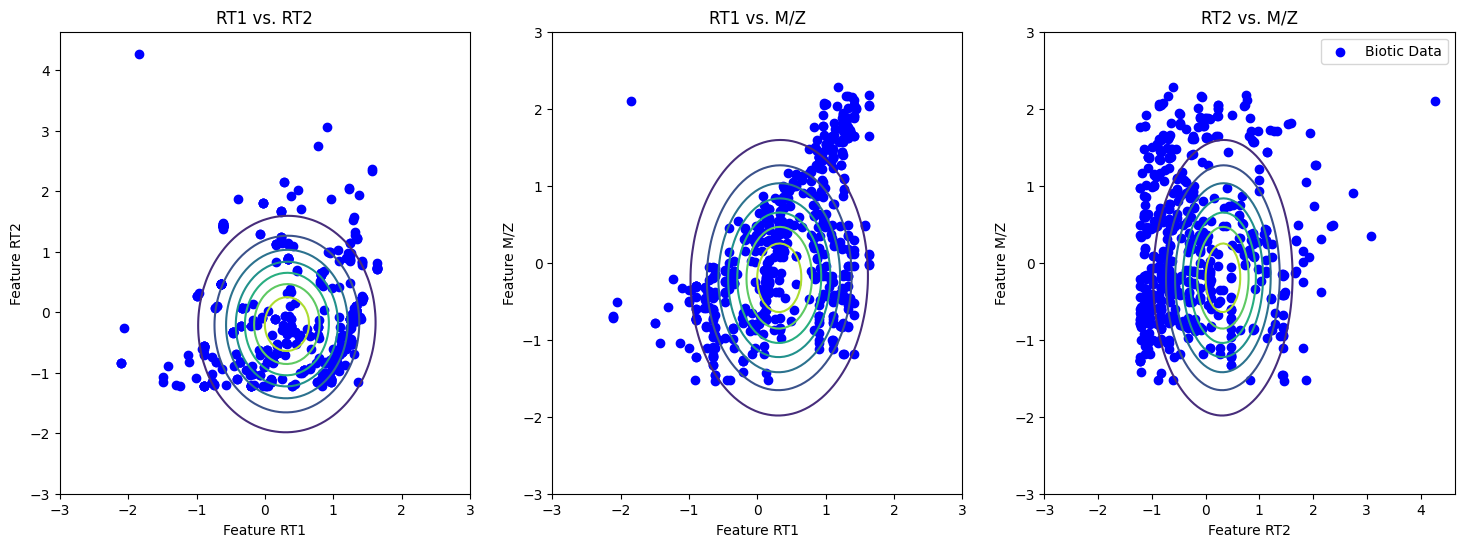

In [9]:
# Function to plot 2D projection with contours
def plot_2d_projection(x_idx, y_idx, features, dist, ax):
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = dist.pdf(np.dstack((X, Y, np.zeros_like(X))))

    feature_names = ['RT1', 'RT2', 'M/Z']

    ax.contour(X, Y, Z, levels=10, cmap='viridis')
    ax.scatter(features[:, x_idx], features[:, y_idx], c='blue', marker='o', label='Biotic Data')
    ax.set_xlabel(f'Feature {feature_names[x_idx]}')
    ax.set_ylabel(f'Feature {feature_names[y_idx]}')
    ax.set_title(f'{feature_names[x_idx]} vs. {feature_names[y_idx]}')

# Plot the data and distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the 2D projections
plot_2d_projection(0, 1, features_class1, dist1, axs[0])  # RT1 vs RT2
plot_2d_projection(0, 2, features_class1, dist1, axs[1])  # RT1 vs m/z
plot_2d_projection(1, 2, features_class1, dist1, axs[2])  # RT2 vs m/z

plt.savefig('mvgd_feature_comparison.pdf', dpi=300)

plt.legend()
plt.show()

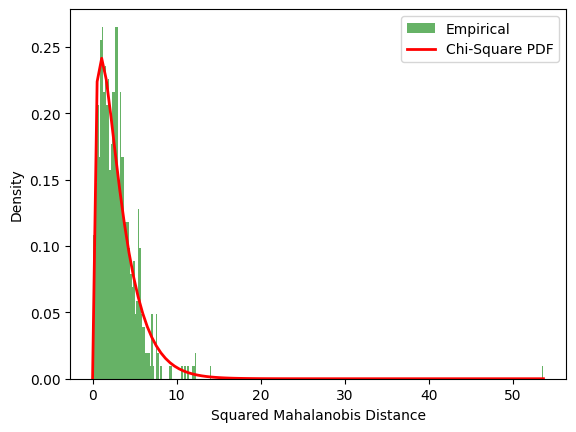

In [212]:
import numpy as np
from scipy.stats import chi2

# Calculate Mahalanobis distances
mean = np.mean(X, axis=0)
cov = np.cov(X, rowvar=False)
inv_cov = np.linalg.inv(cov)

def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))

mahalanobis_dists = np.array([mahalanobis_distance(x, mean, inv_cov) for x in X])
squared_mahalanobis_dists = mahalanobis_dists ** 2

# Plot histogram and compare with chi-square distribution
import matplotlib.pyplot as plt

plt.hist(squared_mahalanobis_dists, bins=300, density=True, alpha=0.6, color='g', label='Empirical')
df = X.shape[1]  # Degrees of freedom
chi2_dist = chi2(df=df)
x = np.linspace(0, np.max(squared_mahalanobis_dists), 100)
plt.plot(x, chi2_dist.pdf(x), 'r-', lw=2, label='Chi-Square PDF')
plt.xlabel('Squared Mahalanobis Distance')
plt.ylabel('Density')
plt.legend()
plt.show()

In [215]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler

# Compute Mahalanobis Distance
mean = np.mean(features_class1, axis=0)
cov = np.cov(features_class1, rowvar=False)
inv_cov = np.linalg.inv(cov)

def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))

mahalanobis_dists = np.array([mahalanobis_distance(x, mean, inv_cov) for x in features_class1])

# Compute p-values using chi-square distribution with degrees of freedom = number of dimensions
df = features_class1.shape[1]
p_values = 1 - chi2.cdf(dists**2, df)

# Print the proportion of points with p-value > 0.05 (i.e., not outliers)
proportion_non_outliers = np.sum(p_values > 0.05) / len(p_values)
print(f"Proportion of non-outliers: {proportion_non_outliers:.2f}")

Proportion of non-outliers: 0.98
